In [1]:
#!/bin/env python3
# conda: gridTools
import sys, os, logging, cartopy
from gridtools.gridutils import GridUtils
%matplotlib inline
from gridtools.datasource import DataSource
import pdb
import xarray as xr

In [10]:
# Work/INPUT directories
nwa25_work = '/Users/james/Documents/Rutgers/gridgen/nwa25_grid/'
nwa25 = os.path.join(nwa25_work, 'ocean_hgrid.nc')
grd = GridUtils()
grd.clearGrid()
grd.openGrid(nwa25)
grd.readGrid()
grd.closeGrid()


In [11]:


grd.setPlotParameters(
    {
        'figsize': (8,8),
        'projection': {
            'name': 'Mercator',
            'lat_0': 35.0,
            'lon_0': 292.0
        },
        'extent': [-100.0 ,-35.0, 3.0, 60.0],
        'iLinewidth': 0.1,
        'jLinewidth': 0.1,
        'showGridCells': True,
        'title': "Mercator: 0.5 deg x 0.5 deg",
        'satelliteHeight': 35785831.0,
        'transform': cartopy.crs.PlateCarree(),
        'iColor': 'k',
        'jColor': 'k'
    }
)


In [ ]:



wrkDir = '/Users/james/Documents/Rutgers/gridgen/gebco_nwa25_grid/'
# define GEBCO file path
bathPath = '/Users/james/Documents/Rutgers/data/GEBCO_2020/GEBCO_2020.nc'
# External data sources are required
# This creates an empty data source catalog
ds = DataSource()

# Connect the catalog to the grid object
grd.useDataSource(ds)

# For variableMap, matching variable values will be renamed to the
# variable key.  For evalMap, variables in the expression need
# to be in brackets.  If the key is new, a new field will be
# created with the given expression.
ds.addDataSource({
    'GEBCO_2020': {
            'url' : 'file:' + bathPath,
            'variableMap' : {
                    'lat': 'lat',
                    'lon': 'lon',
                    'depth' : 'elevation'
                },
            'evalMap': {
                    'depth' : '-[depth]'
                }
        }
})

# define our bathyGrid output filename
bathyGridFilename = os.path.join(wrkDir, 'ocean_topog.nc')

if os.path.isfile(bathyGridFilename):
    bathyGrids = xr.open_dataset(bathyGridFilename)
else:
    # Data sources cannot be in chunked mode for use in this routine - https://github.com/ESMG/gridtools/blob/2c15d5e82a28e1d485e669bbdbd3653be0b54e5b/gridtools/bathyutils.py#L583
    bathyGrids = grd.computeBathymetricRoughness('ds:GEBCO_2020',
            maxMb=99, superGrid=False, useClipping=False,
            FixByOverlapQHGridShift=True,
            auxVariables=['hStd', 'hMin', 'hMax', 'depth'],
    )

    # This is needed to really convert the elevation field to depth
    # The 'depth' field has to be requested as an auxVariables
    grd.applyEvalMap('ds:GEBCO_2020', bathyGrids)
    
    # Write ocean_mask.nc and land_mask.nc based on existing field
    grd.writeOceanmask(bathyGrids, 'depth', 'mask',
            os.path.join(wrkDir, 'ocean_mask.nc'),
            MASKING_DEPTH=0.0)
    grd.writeLandmask(bathyGrids, 'depth', 'mask',
            os.path.join(wrkDir, 'land_mask.nc'),
            MASKING_DEPTH=0.0)

    
    # Argument notes:
    #  * Any ocean mask points shallower than a depth of 1000.0 meters will be set to 1000.0 meters
    #  * Any land mask points that become ocean will be set to a depth of 100.0 meters
    #  * Any ocean points that become land will have a depth of 0.0 meters
    
    bathyGrids['newDepth'] = grd.applyExistingLandmask(bathyGrids, 'depth',
            os.path.join(wrkDir, 'land_mask.nc'), 'mask',
            MASKING_DEPTH=0.0, MINIMUM_DEPTH=0.0, MAXIMUM_DEPTH=-99999.0)
    bathyGrids['newDepth'].attrs['units'] = 'meters'
    bathyGrids['newDepth'].attrs['standard_name'] = 'topographic depth at Arakawa C h-points'

    # Write grid variables out to a file as netCDF
    bathyGrids.to_netcdf(os.path.join(wrkDir, 'ocean_topog_raw.nc'),
            encoding=grd.removeFillValueAttributes(data=bathyGrids))



In [4]:
# Display our ocean_topog_midatlanticLCC.nc file 
wrkDir = '/Users/james/Documents/Rutgers/gridInfo/gebco_nwa25_grid/'
topo = xr.open_dataset(wrkDir + 'ocean_topog.nc')

In [38]:
work_dir = "/Users/james/Documents/Rutgers/gridInfo/nwa25_grid/"
old_land_mask = xr.open_dataset(work_dir + '/land_mask.nc')

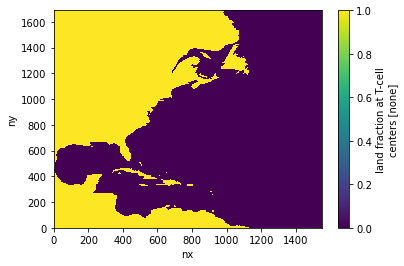

In [39]:
old_land_mask.mask.plot()

### Mask new Topography based on Old Land Mask

This should be done using xarray.where but it's not working properly so we have to do it the hard way

In [40]:
for ny in topo.ny:
    for nx in topo.nx:
        if old_land_mask.mask.values[ny,nx] == 1.0:
            topo.newDepth.values[ny,nx] = 0.0

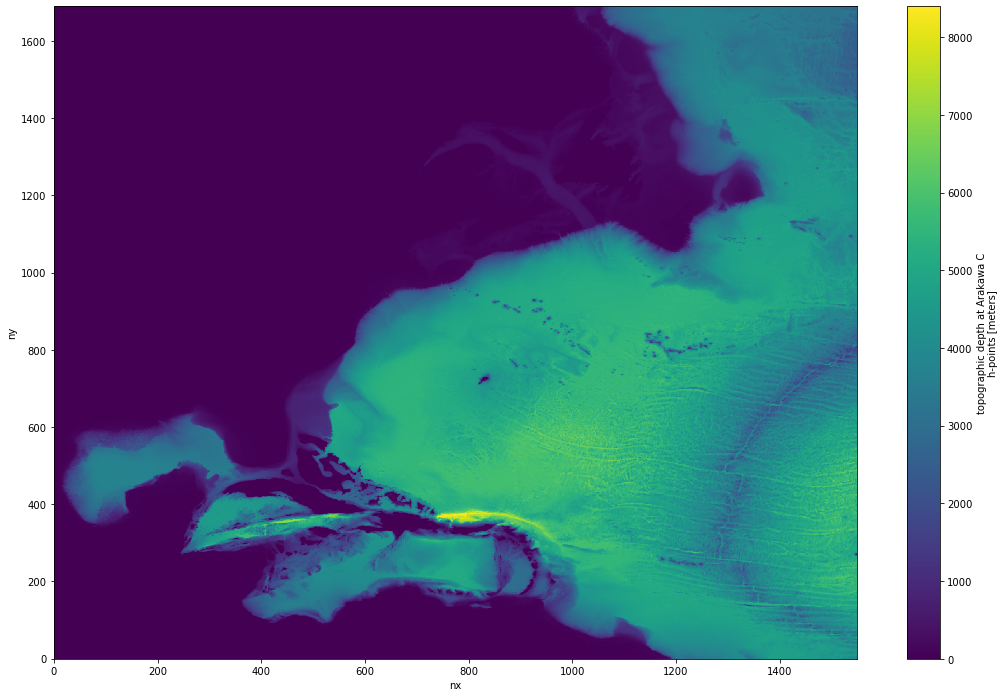

In [7]:
topo.depth.plot(size=12)

In [ ]:
topo.to_netcdf(wrkDir + '/hold/topog_final.nc', format='NETCDF3_CLASSIC')

## Create Mosaic Files

In [3]:
wrkDir = '/Users/james/Documents/Rutgers/gridInfo/gebco_nwa25_grid/'
work_dir = "/Users/james/Documents/Rutgers/gridInfo/nwa25_grid/"
topo = xr.open_dataset(wrkDir + '/hold/topog_final.nc')

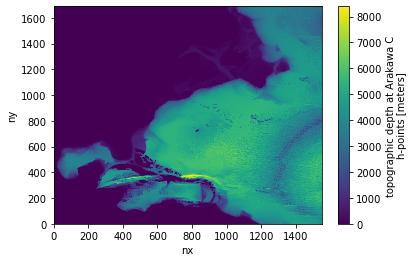

In [4]:
topo.depth.plot()

In [5]:
grd = GridUtils()
grd.openGrid(work_dir + "/ocean_hgrid.nc", gridType='MOM6')
grd.readGrid()

In [6]:
inputDir = wrkDir
# Write out FMS related support files
grd.makeSoloMosaic(
    topographyGrid=topo['depth'],
    writeLandmask=True,
    writeOceanmask=True,
    inputDirectory=inputDir,
    overwrite=True,
)
grd.saveGrid(filename=os.path.join(wrkDir, "ocean_hgrid.nc"))

Successfully wrote netCDF file to /Users/james/Documents/Rutgers/gridInfo/gebco_nwa25_grid/ocean_hgrid.nc


### Change Mask Datatypes

In [7]:
ocean_mask = xr.open_dataset(inputDir + "ocean_mask.nc")
ocean_mask["mask"] = ocean_mask.mask.astype('double')
ocean_mask.to_netcdf(inputDir + "/netcdf3/ocean_mask.nc", mode='w', format='NETCDF3_CLASSIC')

In [8]:
land_mask = xr.open_dataset(inputDir + "land_mask.nc")
land_mask["mask"] = land_mask.mask.astype('double')
land_mask.to_netcdf(inputDir + "/netcdf3/land_mask.nc", mode='w', format='NETCDF3_CLASSIC')

# Convert All Files to NETCDF3 CLASSIC

**THIS MUST BE DONE**

Note that these need to be saved to a new folder. We CANNOT overwrite the files in line here, the data isn't written properly when we do that.

In [9]:
import xarray as xr
from os import listdir
from os.path import isfile, join
myPath = inputDir
fileList = [f for f in listdir(myPath) if isfile(join(myPath, f))]

In [10]:
fileList


['.DS_Store',
 'land_mosaic_tile1Xocean_mosaic_tile1.nc',
 'mosaic.nc',
 'atmos_mosaic_tile1Xocean_mosaic_tile1.nc',
 'ocean_mask.nc',
 'atmos_mosaic_tile1Xland_mosaic_tile1.nc',
 'ocean_mosaic.nc',
 'ocean_hgrid.nc',
 'land_mask.nc',
 'ocean_topog.nc']

In [11]:
fileList.remove('ocean_mask.nc')
fileList.remove('land_mask.nc')


In [12]:
for f in fileList:
    if f.endswith('.nc'):
        print(f)
        tem = xr.open_dataset(myPath + f)
        tem.to_netcdf(path=str(myPath + '/netcdf3/' + f),mode='w',format='NETCDF3_CLASSIC')

land_mosaic_tile1Xocean_mosaic_tile1.nc
mosaic.nc
atmos_mosaic_tile1Xocean_mosaic_tile1.nc
atmos_mosaic_tile1Xland_mosaic_tile1.nc
ocean_mosaic.nc
ocean_hgrid.nc
ocean_topog.nc


### Smooth out Hatteras Bathy...

just to test out if this is why we get that weird gulf phenomenon

In [13]:
import xarray as xr

bathy = xr.open_dataset('/Users/james/Documents/Rutgers/gridInfo/gebco_nwa25_grid/netcdf3/ocean_topog.nc')

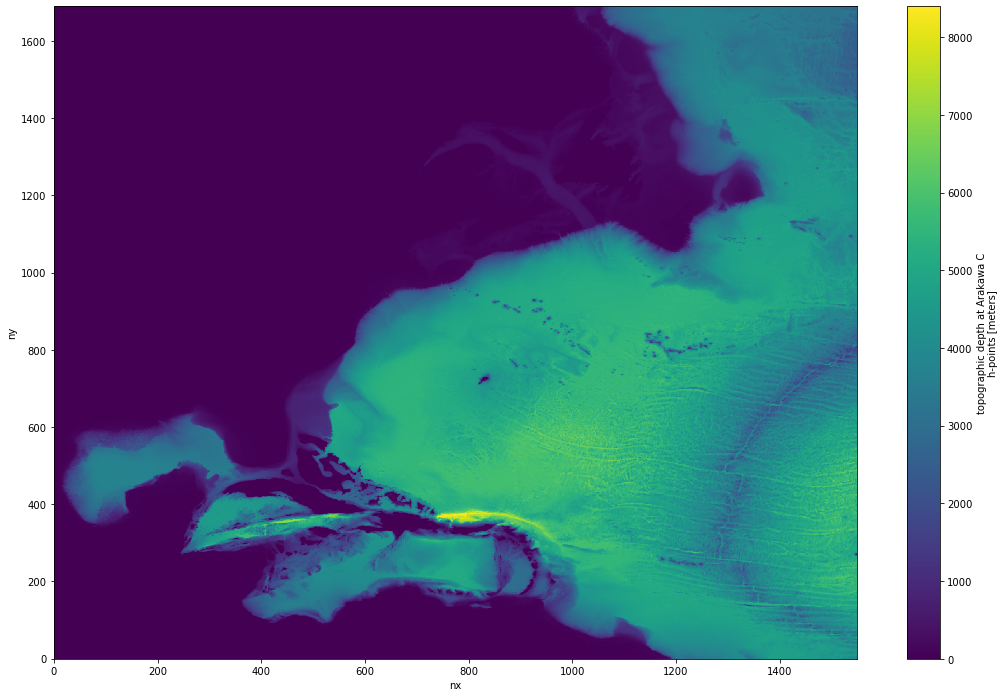

In [14]:
bathy.depth.plot(size=12)

In [15]:
adj = bathy.copy()

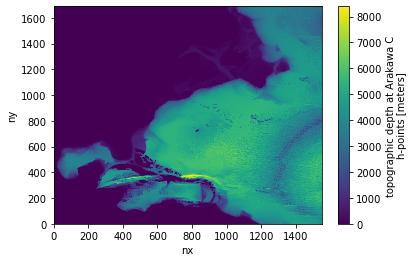

In [16]:
adj.depth.plot()

In [17]:
for ny in adj.ny:
    for nx in adj.nx:
        if adj.depth.values[ny,nx] > 1.0:
            adj.depth.values[ny,nx] = 4000.0

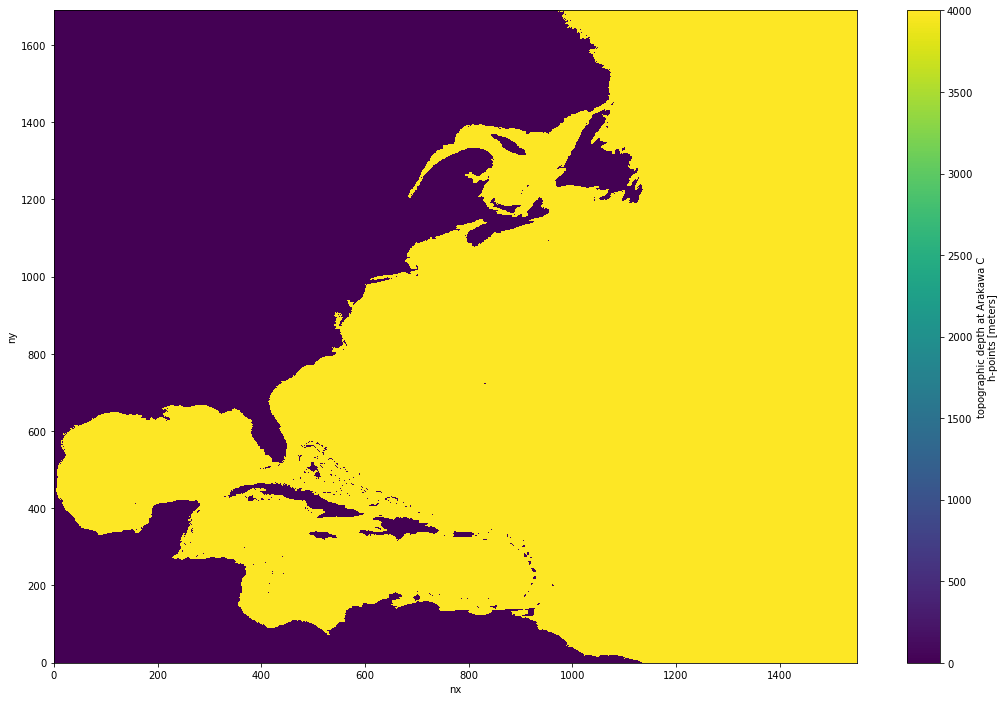

In [18]:
adj.depth.plot(size=12)

In [19]:
adj.to_netcdf('/Users/james/Documents/Rutgers/gridInfo/gebco_nwa25_grid/netcdf3/bulldozed_ocean_topog_4000.nc',format='NETCDF3_CLASSIC')